In [1]:
import librosa
import numpy
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1800

In [3]:
import os
import librosa
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

ambulance_data_dir = '/content/drive/MyDrive/Ambulance data'
road_noises_dir = '/content/drive/MyDrive/Road Noises'

ambulance_audio_files = glob(ambulance_data_dir + '/*.wav')
road_audio_files = glob(road_noises_dir + '/*.wav')

def process_files(file_list, label, chunk_size=100):
    for i in range(0, len(file_list), chunk_size):
        feature_vectors = []
        labels = []
        chunk_files = file_list[i:i + chunk_size]
        for file in chunk_files:
            y , sr = librosa.load(file, sr=44100)
            n_fft = 1024
            if len(y) < n_fft:
                y = np.pad(y, (0, n_fft - len(y)))

            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            mfccs_mean = mfccs.mean(axis=1)

            zcr = librosa.feature.zero_crossing_rate(y)
            zcr_mean = np.mean(zcr)

            rms = librosa.feature.rms(y=y)
            rms_mean = np.mean(rms)

            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            spectral_centroids_mean = np.mean(spectral_centroids)

            spectral_flux = np.mean(np.diff(spectral_centroids))

            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spectrogram_mean = np.mean(mel_spectrogram)

            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_mean = np.mean(chroma)

            contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            contrast_mean = np.mean(contrast)

            tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
            tonnetz_mean = np.mean(tonnetz)

            feature_vectors.append(np.hstack([mfccs_mean, zcr_mean, rms_mean, spectral_centroids_mean, spectral_flux, mel_spectrogram_mean, chroma_mean, contrast_mean, tonnetz_mean]))

            labels.append(label)

        df_features = pd.DataFrame(feature_vectors)
        df_labels = pd.DataFrame(labels, columns=['label'])
        df = pd.concat([df_labels, df_features], axis=1)

        if os.path.exists('/content/combined_features.csv'):
            df.to_csv('/content/combined_features.csv', mode='a', header=False, index=False)
        else:
            df.to_csv('/content/combined_features.csv', index=False)

        del feature_vectors, labels, df_features, df_labels, df



In [ ]:
process_files(ambulance_audio_files, 'vehicle_siren')
process_files(road_audio_files, 'road_Sound')

try:
    df = pd.read_csv('/content/combined_features.csv')
except pd.errors.ParserError:
    print("Error parsing CSV file. Skipping problematic rows.")
    df = pd.read_csv('/content/combined_features.csv', error_bad_lines=False)

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=985
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=493
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=896
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=448
  warnings.warn(


In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense, LSTM
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score
# from sklearn.neural_network import MLPClassifier
# import numpy as np

# # Assuming X_train, y_train, X_test, y_test are defined

# # Training MLP with SKLearn
# mlp = MLPClassifier(random_state=42, max_iter=1000)
# mlp.fit(X_train, y_train)
# mlp_train_preds = mlp.predict(X_train)
# mlp_test_preds = mlp.predict(X_test)

# # Compute the MLP losses
# mlp_train_loss = [1 - accuracy_score(y_train, mlp_train_preds)]
# mlp_test_loss = [1 - accuracy_score(y_test, mlp_test_preds)]

# # Initialize lists to record training and testing accuracy/loss for the three models
# cvscores = {
#     'mlp_train': [mlp.score(X_train, y_train) * 100],
#     'mlp_test': [mlp.score(X_test, y_test) * 100],
#     'dnn_train': [], 'dnn_test': [],
#     'lstm_train': [], 'lstm_test': [],
# }

# losses = {
#     'mlp_train': mlp_train_loss, 'mlp_test': mlp_test_loss,
#     'dnn_train': [], 'dnn_test': [],
#     'lstm_train': [], 'lstm_test': [],
# }

# # Define 5-fold cross validation
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for train, test in kfold.split(X_train, y_train):
#     # Define DNN model
#     dnn = Sequential()
#     dnn.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
#     dnn.add(Dense(1, activation='sigmoid'))
#     dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     # Fit the DNN model
#     history_dnn = dnn.fit(X_train[train], y_train[train], epochs=100, batch_size=32, verbose=0)

#     # Evaluate the DNN model on train and test data
#     scores_dnn_train = dnn.evaluate(X_train[train], y_train[train], verbose=0)
#     scores_dnn_test = dnn.evaluate(X_train[test], y_train[test], verbose=0)
#     cvscores['dnn_train'].append(scores_dnn_train[1] * 100)
#     cvscores['dnn_test'].append(scores_dnn_test[1] * 100)
#     losses['dnn_train'].append(scores_dnn_train[0])
#     losses['dnn_test'].append(scores_dnn_test[0])

#     # Stack the predictions together to serve as the input for the LSTM model
#     dnn_preds = dnn.predict(X_train)
#     dnn_preds = (dnn_preds > 0.5).astype(int)
#     stacked_predictions = np.column_stack((mlp_train_preds, dnn_preds))
#     stacked_predictions = stacked_predictions.reshape((stacked_predictions.shape[0], stacked_predictions.shape[1], 1))

#     # Define LSTM model
#     lstm = Sequential()
#     lstm.add(LSTM(32, activation='tanh', input_shape=(stacked_predictions.shape[1], 1)))
#     lstm.add(Dense(1, activation='sigmoid'))
#     lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     # Fit the LSTM model
#     history_lstm = lstm.fit(stacked_predictions[train], y_train[train], epochs=100, batch_size=32, verbose=0)

#     # Evaluate the LSTM model on train and test data
#     scores_lstm_train = lstm.evaluate(stacked_predictions[train], y_train[train], verbose=0)
#     scores_lstm_test = lstm.evaluate(stacked_predictions[test], y_train[test], verbose=0)
#     cvscores['lstm_train'].append(scores_lstm_train[1] * 100)
#     cvscores['lstm_test'].append(scores_lstm_test[1] * 100)
#     losses['lstm_train'].append(scores_lstm_train[0])
#     losses['lstm_test'].append(scores_lstm_test[0])


#     # accuracy['MLP Train'] = cvscores['mlp_train']
#     # accuracy['MLP Test'] = cvscores['mlp_test']
#     # accuracy['DNN Train'] = cvscores['dnn_train']
#     # accuracy['DNN Test'] = cvscores['dnn_test']
#     # accuracy['LSTM Train'] = cvscores['lstm_train']
#     # accuracy['LSTM Test'] = cvscores['lstm_test']

#     # loss['MLP Train'] = losses['mlp_train']
#     # loss['MLP Test'] = losses['mlp_test']
#     # loss['DNN Train'] = losses['dnn_train']
#     # loss['DNN Test'] = losses['dnn_test']
#     # loss['LSTM Train'] = losses['lstm_train']
#     # loss['LSTM Test'] = losses['lstm_test']


NameError: ignored

# Meta Model

12/12 [==============================] - 0s 2ms/step
LSTM Train accuracy = 0.9993183367416496
LSTM Test accuracy = 0.9754768392370572
DNN Train accuracy = 0.9952283571915473
DNN Test accuracy = 0.9645776566757494
MLP Train accuracy = 0.9754768392370572
MLP Test accuracy = 0.9754768392370572


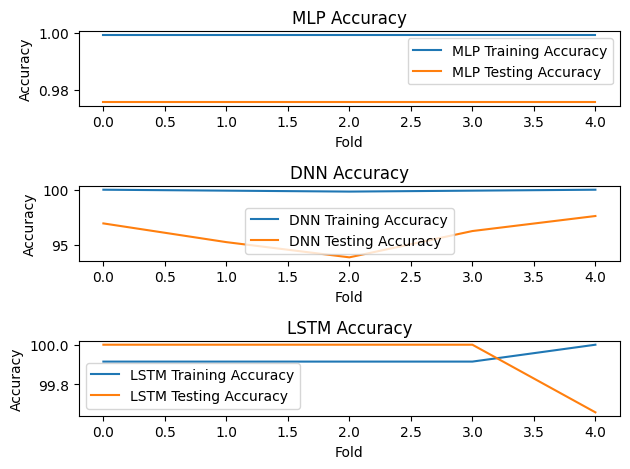

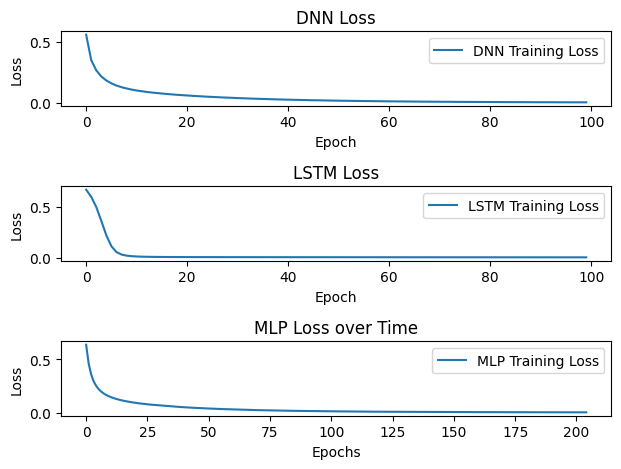

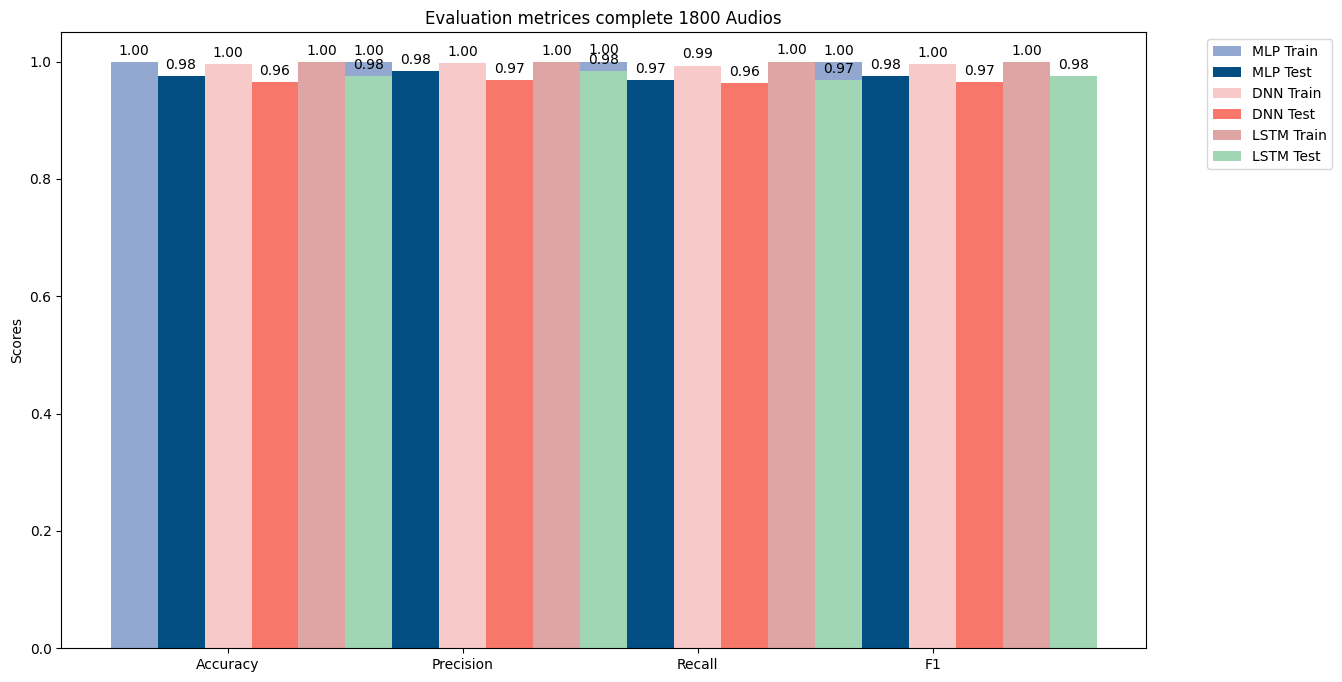

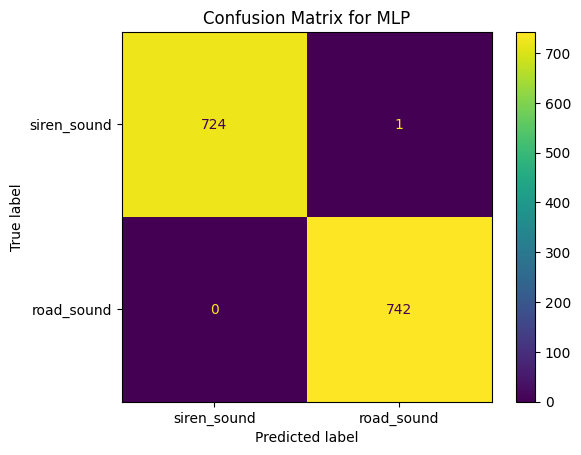

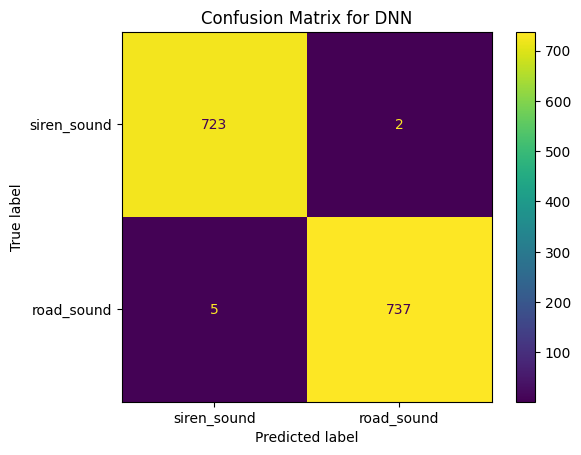

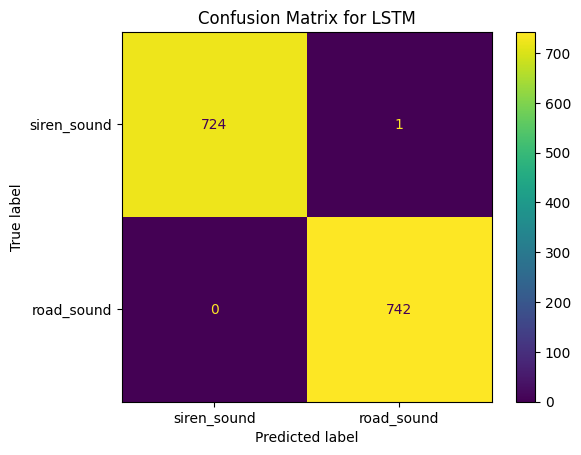

46/46 [==============================] - 0s 2ms/step


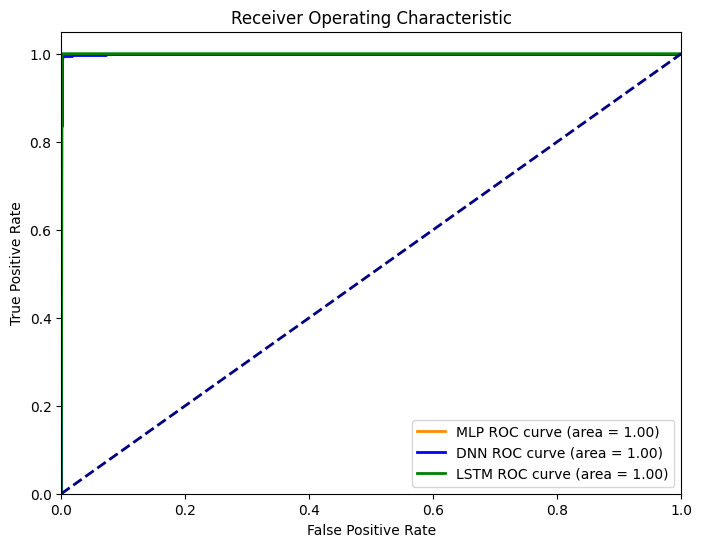

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train a MLPClassifier
mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp.fit(X_train, y_train)


# Use MLP to make predictions on the training data
mlp_train_preds = mlp.predict(X_train)
mlp_test_preds = mlp.predict(X_test)

# Calculate and print MLP accuracy, precision, recall, and F1 score
mlp_train_accuracy = accuracy_score(y_train, mlp_train_preds)
mlp_test_accuracy = accuracy_score(y_test, mlp_test_preds)
mlp_train_precision = precision_score(y_train, mlp_train_preds)
mlp_test_precision = precision_score(y_test, mlp_test_preds)
mlp_train_recall = recall_score(y_train, mlp_train_preds)
mlp_test_recall = recall_score(y_test, mlp_test_preds)
mlp_train_f1 = f1_score(y_train, mlp_train_preds)
mlp_test_f1 = f1_score(y_test, mlp_test_preds)



# Define 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores_dnn_train = []
cvscores_dnn_test = []
cvscores_lstm_train = []
cvscores_lstm_test = []
dnn_train_losses = []
lstm_train_losses=[]

for train, test in kfold.split(X_train, y_train):
    # Define DNN model
    dnn = Sequential()
    dnn.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    dnn.add(Dense(1, activation='sigmoid'))
    dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the DNN model
    history_dnn = dnn.fit(X_train[train], y_train[train], epochs=100, batch_size=32, verbose=0)
    dnn_train_losses.append(history_dnn.history['loss'])

    # Evaluate the DNN model on train and test data
    scores_dnn_train = dnn.evaluate(X_train[train], y_train[train], verbose=0)
    scores_dnn_test = dnn.evaluate(X_train[test], y_train[test], verbose=0)
    cvscores_dnn_train.append(scores_dnn_train[1] * 100)
    cvscores_dnn_test.append(scores_dnn_test[1] * 100)

    # Use the 'predict' function and threshold the results for binary classification
    dnn_preds_proba = dnn.predict(X_train)
    dnn_preds = (dnn_preds_proba > 0.5).astype(int)

    dnn_test_preds = dnn.predict(X_test)
    dnn_test_preds = (dnn_test_preds > 0.5).astype(int)
    # Stack the predictions together to serve as the input for the LSTM model
    stacked_predictions = np.column_stack((mlp_train_preds, dnn_preds))
    stacked_predictions_test = np.column_stack((mlp_test_preds, dnn_test_preds))
    stacked_predictions_test = stacked_predictions_test.reshape((stacked_predictions_test.shape[0], stacked_predictions_test.shape[1], 1))

    # Reshape the stacked predictions to 3D because LSTM expects input to be 3D
    stacked_predictions = stacked_predictions.reshape((stacked_predictions.shape[0], stacked_predictions.shape[1], 1))

    # Define LSTM model
    lstm = Sequential()
    lstm.add(LSTM(32, activation='tanh', input_shape=(stacked_predictions.shape[1], 1)))
    lstm.add(Dense(1, activation='sigmoid'))
    lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the LSTM model
    history_lstm = lstm.fit(stacked_predictions[train], y_train[train], epochs=100, batch_size=32, verbose=0)
    lstm_train_losses.append(history_lstm.history['loss'])

    # Evaluate the LSTM model on train and test data
    scores_lstm_train = lstm.evaluate(stacked_predictions[train], y_train[train], verbose=0)
    scores_lstm_test = lstm.evaluate(stacked_predictions[test], y_train[test], verbose=0)
    cvscores_lstm_train.append(scores_lstm_train[1] * 100)
    cvscores_lstm_test.append(scores_lstm_test[1] * 100)

    dnn_train_precision = precision_score(y_train, dnn_preds, average='binary')
    dnn_train_recall = recall_score(y_train, dnn_preds, average='binary')
    dnn_train_f1 = f1_score(y_train, dnn_preds, average='binary')

    dnn_test_precision = precision_score(y_test, dnn_test_preds, average='binary')
    dnn_test_recall = recall_score(y_test, dnn_test_preds, average='binary')
    dnn_test_f1 = f1_score(y_test, dnn_test_preds, average='binary')
    lstm_train_preds = lstm.predict(stacked_predictions)
    lstm_train_preds = (lstm_train_preds > 0.5).astype(int)
    lstm_train_precision = precision_score(y_train, lstm_train_preds, average='binary')
    lstm_train_recall = recall_score(y_train, lstm_train_preds, average='binary')
    lstm_train_f1 = f1_score(y_train, lstm_train_preds, average='binary')

    lstm_test_preds = lstm.predict(stacked_predictions_test)
    lstm_test_preds = (lstm_test_preds > 0.5).astype(int)
    lstm_test_precision = precision_score(y_test, lstm_test_preds, average='binary')
    lstm_test_recall = recall_score(y_test, lstm_test_preds, average='binary')
    lstm_test_f1 = f1_score(y_test, lstm_test_preds, average='binary')
    dnn_train_accuracy = accuracy_score(y_train, dnn_preds)
    dnn_test_accuracy = accuracy_score(y_test, dnn_test_preds)
    lstm_train_accuracy = accuracy_score(y_train, lstm_train_preds)
    lstm_test_accuracy = accuracy_score(y_test, lstm_test_preds)

print("LSTM Train accuracy =", lstm_train_accuracy)
print("LSTM Test accuracy =", lstm_test_accuracy)
print("DNN Train accuracy =", dnn_train_accuracy)
print("DNN Test accuracy =",  dnn_test_accuracy)
print("MLP Train accuracy =", mlp_test_accuracy)
print("MLP Test accuracy =", mlp_test_accuracy)

fig, axs = plt.subplots(3)
# Plot MLP training and testing accuracy
axs[0].plot([mlp_train_accuracy] * 5, label='MLP Training Accuracy')
axs[0].plot([mlp_test_accuracy] * 5, label='MLP Testing Accuracy')
axs[0].set_title('MLP Accuracy')
axs[0].set_xlabel('Fold')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot DNN training and testing accuracy
axs[1].plot(cvscores_dnn_train, label='DNN Training Accuracy')
axs[1].plot(cvscores_dnn_test, label='DNN Testing Accuracy')
axs[1].set_title('DNN Accuracy')
axs[1].set_xlabel('Fold')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plot LSTM training and testing accuracy
axs[2].plot(cvscores_lstm_train, label='LSTM Training Accuracy')
axs[2].plot(cvscores_lstm_test, label='LSTM Testing Accuracy')
axs[2].set_title('LSTM Accuracy')
axs[2].set_xlabel('Fold')
axs[2].set_ylabel('Accuracy')
axs[2].legend()

# Display the figure with subplots
plt.tight_layout()
plt.show()
fig, axs = plt.subplots(3)

# Plot DNN training loss
axs[0].plot(np.mean(dnn_train_losses, axis=0), label='DNN Training Loss')
axs[0].set_title('DNN Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot LSTM training loss
axs[1].plot(np.mean(lstm_train_losses, axis=0), label='LSTM Training Loss')
axs[1].set_title('LSTM Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Plot MLP loss over epochs
axs[2].plot(mlp.loss_curve_, label='MLP Training Loss')
axs[2].set_title('MLP Loss over Time')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].legend()

# Display the figure with subplots
plt.tight_layout()
plt.show()


# Calculate the average of each metric
dnn_metrics_train = [np.mean(dnn_train_accuracy), np.mean(dnn_train_precision), np.mean(dnn_train_recall), np.mean(dnn_train_f1)]
dnn_metrics_test = [np.mean(dnn_test_accuracy), np.mean(dnn_test_precision), np.mean(dnn_test_recall), np.mean(dnn_test_f1)]

lstm_metrics_train = [np.mean(lstm_train_accuracy), np.mean(lstm_train_precision), np.mean(lstm_train_recall), np.mean(lstm_train_f1)]
lstm_metrics_test = [np.mean(lstm_test_accuracy), np.mean(lstm_test_precision), np.mean(lstm_test_recall), np.mean(lstm_test_f1)]
# Assuming you have already computed the metrics for the MLP model...
mlp_metrics_train = [np.mean(mlp_train_accuracy), np.mean(mlp_train_precision), np.mean(mlp_train_recall), np.mean(mlp_train_f1)]
mlp_metrics_test = [np.mean(mlp_test_accuracy), np.mean(mlp_test_precision), np.mean(mlp_test_recall), np.mean(mlp_test_f1)]

# Define labels and bar width
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars


colors = ['#92a8d1', '#034f84', '#f7cac9', '#f7786b', '#dea5a4', '#a0d6b4']

fig, ax = plt.subplots(figsize=(14, 8))  # Increase figure size
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),  # limit to 2 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# Add MLP bars to the plot
rects1 = ax.bar(x - 2*width, mlp_metrics_train, width, label='MLP Train', color=colors[0])
rects2 = ax.bar(x - width, mlp_metrics_test, width, label='MLP Test', color=colors[1])

# Add DNN and LSTM bars to the plot
rects3 = ax.bar(x, dnn_metrics_train, width, label='DNN Train', color=colors[2])
rects4 = ax.bar(x + width, dnn_metrics_test, width, label='DNN Test', color=colors[3])
rects5 = ax.bar(x + 2*width, lstm_metrics_train, width, label='LSTM Train', color=colors[4])
rects6 = ax.bar(x + 3*width, lstm_metrics_test, width, label='LSTM Test', color=colors[5])  # now colors[5] exists

# Add labels, title, legend, and x-ticks
ax.set_ylabel('Scores')
ax.set_title('Evaluation metrices complete 1800 Audios')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Existing code...
ax.set_xticklabels(labels)

# Adjust the position of the legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Existing code...
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

from sklearn.metrics import confusion_matrix

# Compute confusion matrix for each model
mlp_cm = confusion_matrix(y_train, mlp_train_preds)
dnn_cm = confusion_matrix(y_train, dnn_preds)
lstm_cm = confusion_matrix(y_train, lstm_train_preds)
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix for MLP
disp = ConfusionMatrixDisplay(confusion_matrix=mlp_cm, display_labels=['siren_sound', 'road_sound'])
disp.plot()
plt.title('Confusion Matrix for MLP')
plt.show()

# Plot confusion matrix for DNN
disp = ConfusionMatrixDisplay(confusion_matrix=dnn_cm, display_labels=['siren_sound', 'road_sound'])
disp.plot()
plt.title('Confusion Matrix for DNN')
plt.show()

# Plot confusion matrix for LSTM
disp = ConfusionMatrixDisplay(confusion_matrix=lstm_cm, display_labels=['siren_sound', 'road_sound'])
disp.plot()
plt.title('Confusion Matrix for LSTM')
plt.show()
from sklearn.metrics import roc_curve, auc

# MLP
mlp_preds_proba = mlp.predict_proba(X_train)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_train, mlp_preds_proba)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# DNN
dnn_preds_proba = dnn.predict(X_train).ravel()
fpr_dnn, tpr_dnn, _ = roc_curve(y_train, dnn_preds_proba)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# LSTM
lstm_preds_proba = lstm.predict(stacked_predictions).ravel()
fpr_lstm, tpr_lstm, _ = roc_curve(y_train, lstm_preds_proba)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp)
plt.plot(fpr_dnn, tpr_dnn, color='blue', lw=2, label='DNN ROC curve (area = %0.2f)' % roc_auc_dnn)
plt.plot(fpr_lstm, tpr_lstm, color='green', lw=2, label='LSTM ROC curve (area = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()




#600 AUDIOS

In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

ambulance_data_dir = '/content/drive/MyDrive/Ambulance data'
road_noises_dir = '/content/drive/MyDrive/Road Noises'

ambulance_audio_files = glob(ambulance_data_dir + '/*.wav')[:300]
road_audio_files = glob(road_noises_dir + '/*.wav')[:300]

def process_files(file_list, label, chunk_size=100):
    for i in range(0, len(file_list), chunk_size):
        feature_vectors = []
        labels = []
        chunk_files = file_list[i:i + chunk_size]
        for file in chunk_files:
            y , sr = librosa.load(file, sr=44100)
            n_fft = 1024
            if len(y) < n_fft:
                y = np.pad(y, (0, n_fft - len(y)))

            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            mfccs_mean = mfccs.mean(axis=1)

            zcr = librosa.feature.zero_crossing_rate(y)
            zcr_mean = np.mean(zcr)

            rms = librosa.feature.rms(y=y)
            rms_mean = np.mean(rms)

            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            spectral_centroids_mean = np.mean(spectral_centroids)

            spectral_flux = np.mean(np.diff(spectral_centroids))

            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spectrogram_mean = np.mean(mel_spectrogram)

            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_mean = np.mean(chroma)

            contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            contrast_mean = np.mean(contrast)

            tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
            tonnetz_mean = np.mean(tonnetz)

            feature_vectors.append(np.hstack([mfccs_mean, zcr_mean, rms_mean, spectral_centroids_mean, spectral_flux, mel_spectrogram_mean, chroma_mean, contrast_mean, tonnetz_mean]))

            labels.append(label)

        df_features = pd.DataFrame(feature_vectors)
        df_labels = pd.DataFrame(labels, columns=['label'])
        df = pd.concat([df_labels, df_features], axis=1)

        if os.path.exists('/content/combined_features.csv'):
            df.to_csv('/content/combined_features.csv', mode='a', header=False, index=False)
        else:
            df.to_csv('/content/combined_features.csv', index=False)

        del feature_vectors, labels, df_features, df_labels, df

process_files(ambulance_audio_files, 'vehicle_siren')
process_files(road_audio_files, 'road_Sound')

try:
    df = pd.read_csv('/content/combined_features.csv')
except pd.errors.ParserError:
    print("Error parsing CSV file. Skipping problematic rows.")
    df = pd.read_csv('/content/combined_features.csv', error_bad_lines=False)

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=914
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=879
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=845
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=1017
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=931
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=786
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256:

#Meta Model

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


16/16 [==============================] - 0s 2ms/step
LSTM Train accuracy = 1.0
LSTM Test accuracy = 0.9753593429158111
DNN Train accuracy = 0.9958911145351823
DNN Test accuracy = 0.9650924024640657
MLP Train accuracy = 0.9753593429158111
MLP Test accuracy = 0.9753593429158111


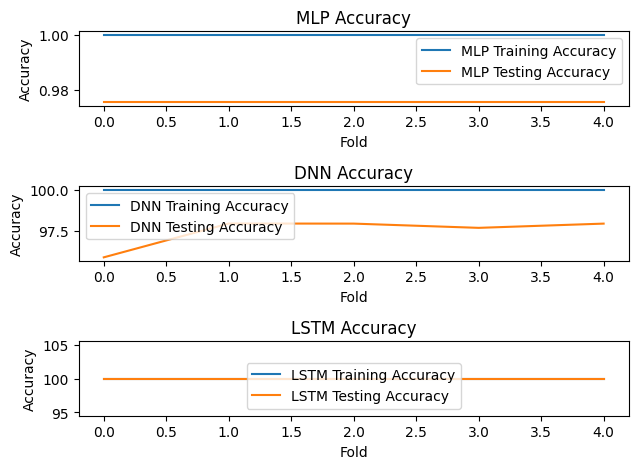

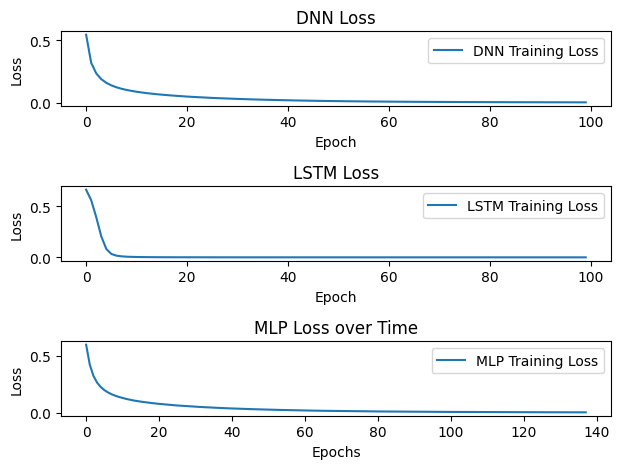

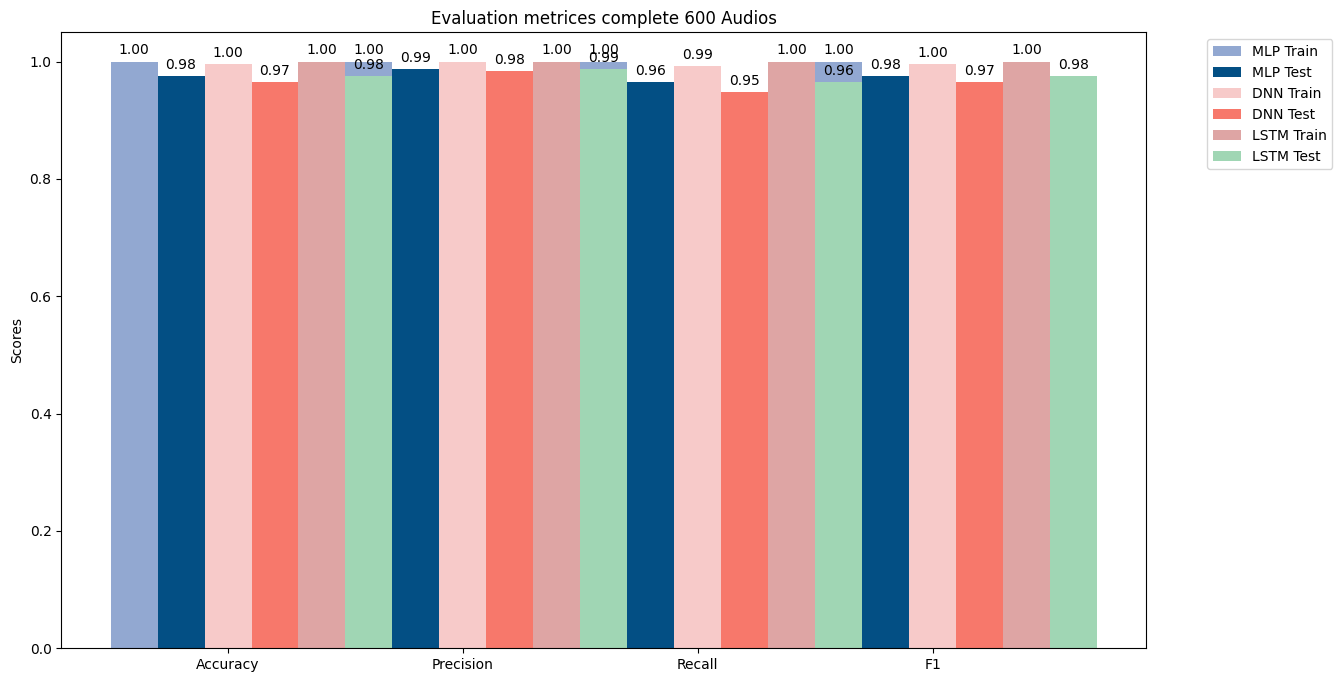

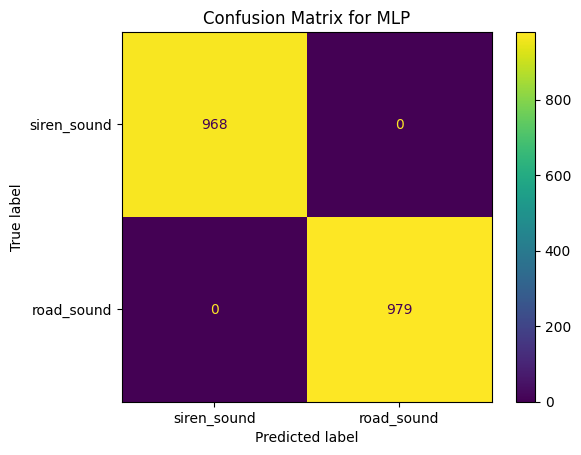

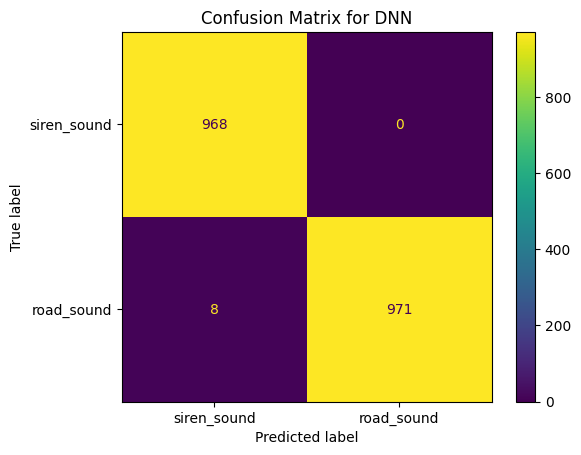

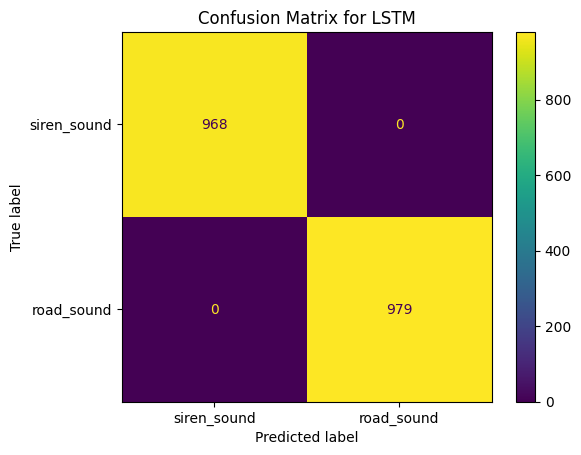

61/61 [==============================] - 0s 2ms/step


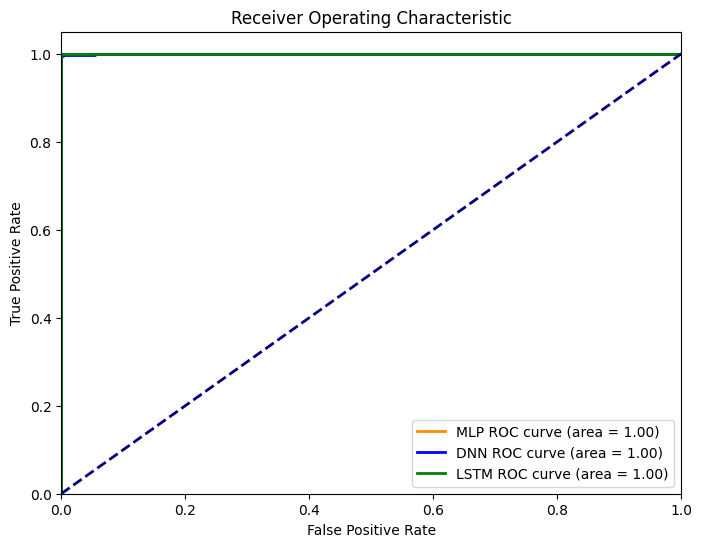

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train a MLPClassifier
mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp.fit(X_train, y_train)


# Use MLP to make predictions on the training data
mlp_train_preds = mlp.predict(X_train)
mlp_test_preds = mlp.predict(X_test)

# Calculate and print MLP accuracy, precision, recall, and F1 score
mlp_train_accuracy = accuracy_score(y_train, mlp_train_preds)
mlp_test_accuracy = accuracy_score(y_test, mlp_test_preds)
mlp_train_precision = precision_score(y_train, mlp_train_preds)
mlp_test_precision = precision_score(y_test, mlp_test_preds)
mlp_train_recall = recall_score(y_train, mlp_train_preds)
mlp_test_recall = recall_score(y_test, mlp_test_preds)
mlp_train_f1 = f1_score(y_train, mlp_train_preds)
mlp_test_f1 = f1_score(y_test, mlp_test_preds)



# Define 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores_dnn_train = []
cvscores_dnn_test = []
cvscores_lstm_train = []
cvscores_lstm_test = []
dnn_train_losses = []
lstm_train_losses=[]

for train, test in kfold.split(X_train, y_train):
    # Define DNN model
    dnn = Sequential()
    dnn.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    dnn.add(Dense(1, activation='sigmoid'))
    dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the DNN model
    history_dnn = dnn.fit(X_train[train], y_train[train], epochs=100, batch_size=32, verbose=0)
    dnn_train_losses.append(history_dnn.history['loss'])

    # Evaluate the DNN model on train and test data
    scores_dnn_train = dnn.evaluate(X_train[train], y_train[train], verbose=0)
    scores_dnn_test = dnn.evaluate(X_train[test], y_train[test], verbose=0)
    cvscores_dnn_train.append(scores_dnn_train[1] * 100)
    cvscores_dnn_test.append(scores_dnn_test[1] * 100)

    # Use the 'predict' function and threshold the results for binary classification
    dnn_preds_proba = dnn.predict(X_train)
    dnn_preds = (dnn_preds_proba > 0.5).astype(int)

    dnn_test_preds = dnn.predict(X_test)
    dnn_test_preds = (dnn_test_preds > 0.5).astype(int)
    # Stack the predictions together to serve as the input for the LSTM model
    stacked_predictions = np.column_stack((mlp_train_preds, dnn_preds))
    stacked_predictions_test = np.column_stack((mlp_test_preds, dnn_test_preds))
    stacked_predictions_test = stacked_predictions_test.reshape((stacked_predictions_test.shape[0], stacked_predictions_test.shape[1], 1))

    # Reshape the stacked predictions to 3D because LSTM expects input to be 3D
    stacked_predictions = stacked_predictions.reshape((stacked_predictions.shape[0], stacked_predictions.shape[1], 1))

    # Define LSTM model
    lstm = Sequential()
    lstm.add(LSTM(32, activation='tanh', input_shape=(stacked_predictions.shape[1], 1)))
    lstm.add(Dense(1, activation='sigmoid'))
    lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the LSTM model
    history_lstm = lstm.fit(stacked_predictions[train], y_train[train], epochs=100, batch_size=32, verbose=0)
    lstm_train_losses.append(history_lstm.history['loss'])

    # Evaluate the LSTM model on train and test data
    scores_lstm_train = lstm.evaluate(stacked_predictions[train], y_train[train], verbose=0)
    scores_lstm_test = lstm.evaluate(stacked_predictions[test], y_train[test], verbose=0)
    cvscores_lstm_train.append(scores_lstm_train[1] * 100)
    cvscores_lstm_test.append(scores_lstm_test[1] * 100)

    dnn_train_precision = precision_score(y_train, dnn_preds, average='binary')
    dnn_train_recall = recall_score(y_train, dnn_preds, average='binary')
    dnn_train_f1 = f1_score(y_train, dnn_preds, average='binary')

    dnn_test_precision = precision_score(y_test, dnn_test_preds, average='binary')
    dnn_test_recall = recall_score(y_test, dnn_test_preds, average='binary')
    dnn_test_f1 = f1_score(y_test, dnn_test_preds, average='binary')
    lstm_train_preds = lstm.predict(stacked_predictions)
    lstm_train_preds = (lstm_train_preds > 0.5).astype(int)
    lstm_train_precision = precision_score(y_train, lstm_train_preds, average='binary')
    lstm_train_recall = recall_score(y_train, lstm_train_preds, average='binary')
    lstm_train_f1 = f1_score(y_train, lstm_train_preds, average='binary')

    lstm_test_preds = lstm.predict(stacked_predictions_test)
    lstm_test_preds = (lstm_test_preds > 0.5).astype(int)
    lstm_test_precision = precision_score(y_test, lstm_test_preds, average='binary')
    lstm_test_recall = recall_score(y_test, lstm_test_preds, average='binary')
    lstm_test_f1 = f1_score(y_test, lstm_test_preds, average='binary')
    dnn_train_accuracy = accuracy_score(y_train, dnn_preds)
    dnn_test_accuracy = accuracy_score(y_test, dnn_test_preds)
    lstm_train_accuracy = accuracy_score(y_train, lstm_train_preds)
    lstm_test_accuracy = accuracy_score(y_test, lstm_test_preds)

print("LSTM Train accuracy =", lstm_train_accuracy)
print("LSTM Test accuracy =", lstm_test_accuracy)
print("DNN Train accuracy =", dnn_train_accuracy)
print("DNN Test accuracy =",  dnn_test_accuracy)
print("MLP Train accuracy =", mlp_test_accuracy)
print("MLP Test accuracy =", mlp_test_accuracy)

fig, axs = plt.subplots(3)
# Plot MLP training and testing accuracy
axs[0].plot([mlp_train_accuracy] * 5, label='MLP Training Accuracy')
axs[0].plot([mlp_test_accuracy] * 5, label='MLP Testing Accuracy')
axs[0].set_title('MLP Accuracy')
axs[0].set_xlabel('Fold')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot DNN training and testing accuracy
axs[1].plot(cvscores_dnn_train, label='DNN Training Accuracy')
axs[1].plot(cvscores_dnn_test, label='DNN Testing Accuracy')
axs[1].set_title('DNN Accuracy')
axs[1].set_xlabel('Fold')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plot LSTM training and testing accuracy
axs[2].plot(cvscores_lstm_train, label='LSTM Training Accuracy')
axs[2].plot(cvscores_lstm_test, label='LSTM Testing Accuracy')
axs[2].set_title('LSTM Accuracy')
axs[2].set_xlabel('Fold')
axs[2].set_ylabel('Accuracy')
axs[2].legend()

# Display the figure with subplots
plt.tight_layout()
plt.show()
fig, axs = plt.subplots(3)

# Plot DNN training loss
axs[0].plot(np.mean(dnn_train_losses, axis=0), label='DNN Training Loss')
axs[0].set_title('DNN Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot LSTM training loss
axs[1].plot(np.mean(lstm_train_losses, axis=0), label='LSTM Training Loss')
axs[1].set_title('LSTM Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Plot MLP loss over epochs
axs[2].plot(mlp.loss_curve_, label='MLP Training Loss')
axs[2].set_title('MLP Loss over Time')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].legend()

# Display the figure with subplots
plt.tight_layout()
plt.show()


# Calculate the average of each metric
dnn_metrics_train = [np.mean(dnn_train_accuracy), np.mean(dnn_train_precision), np.mean(dnn_train_recall), np.mean(dnn_train_f1)]
dnn_metrics_test = [np.mean(dnn_test_accuracy), np.mean(dnn_test_precision), np.mean(dnn_test_recall), np.mean(dnn_test_f1)]

lstm_metrics_train = [np.mean(lstm_train_accuracy), np.mean(lstm_train_precision), np.mean(lstm_train_recall), np.mean(lstm_train_f1)]
lstm_metrics_test = [np.mean(lstm_test_accuracy), np.mean(lstm_test_precision), np.mean(lstm_test_recall), np.mean(lstm_test_f1)]
# Assuming you have already computed the metrics for the MLP model...
mlp_metrics_train = [np.mean(mlp_train_accuracy), np.mean(mlp_train_precision), np.mean(mlp_train_recall), np.mean(mlp_train_f1)]
mlp_metrics_test = [np.mean(mlp_test_accuracy), np.mean(mlp_test_precision), np.mean(mlp_test_recall), np.mean(mlp_test_f1)]

# Define labels and bar width
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars


colors = ['#92a8d1', '#034f84', '#f7cac9', '#f7786b', '#dea5a4', '#a0d6b4']

fig, ax = plt.subplots(figsize=(14, 8))  # Increase figure size
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),  # limit to 2 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# Add MLP bars to the plot
rects1 = ax.bar(x - 2*width, mlp_metrics_train, width, label='MLP Train', color=colors[0])
rects2 = ax.bar(x - width, mlp_metrics_test, width, label='MLP Test', color=colors[1])

# Add DNN and LSTM bars to the plot
rects3 = ax.bar(x, dnn_metrics_train, width, label='DNN Train', color=colors[2])
rects4 = ax.bar(x + width, dnn_metrics_test, width, label='DNN Test', color=colors[3])
rects5 = ax.bar(x + 2*width, lstm_metrics_train, width, label='LSTM Train', color=colors[4])
rects6 = ax.bar(x + 3*width, lstm_metrics_test, width, label='LSTM Test', color=colors[5])  # now colors[5] exists

# Add labels, title, legend, and x-ticks
ax.set_ylabel('Scores')
ax.set_title('Evaluation metrices complete 600 Audios')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Existing code...
ax.set_xticklabels(labels)

# Adjust the position of the legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Existing code...
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

from sklearn.metrics import confusion_matrix

# Compute confusion matrix for each model
mlp_cm = confusion_matrix(y_train, mlp_train_preds)
dnn_cm = confusion_matrix(y_train, dnn_preds)
lstm_cm = confusion_matrix(y_train, lstm_train_preds)
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix for MLP
disp = ConfusionMatrixDisplay(confusion_matrix=mlp_cm, display_labels=['siren_sound', 'road_sound'])
disp.plot()
plt.title('Confusion Matrix for MLP')
plt.show()

# Plot confusion matrix for DNN
disp = ConfusionMatrixDisplay(confusion_matrix=dnn_cm, display_labels=['siren_sound', 'road_sound'])
disp.plot()
plt.title('Confusion Matrix for DNN')
plt.show()

# Plot confusion matrix for LSTM
disp = ConfusionMatrixDisplay(confusion_matrix=lstm_cm, display_labels=['siren_sound', 'road_sound'])
disp.plot()
plt.title('Confusion Matrix for LSTM')
plt.show()
from sklearn.metrics import roc_curve, auc

# MLP
mlp_preds_proba = mlp.predict_proba(X_train)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_train, mlp_preds_proba)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# DNN
dnn_preds_proba = dnn.predict(X_train).ravel()
fpr_dnn, tpr_dnn, _ = roc_curve(y_train, dnn_preds_proba)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# LSTM
lstm_preds_proba = lstm.predict(stacked_predictions).ravel()
fpr_lstm, tpr_lstm, _ = roc_curve(y_train, lstm_preds_proba)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp)
plt.plot(fpr_dnn, tpr_dnn, color='blue', lw=2, label='DNN ROC curve (area = %0.2f)' % roc_auc_dnn)
plt.plot(fpr_lstm, tpr_lstm, color='green', lw=2, label='LSTM ROC curve (area = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()




#1000 AUDIOS

In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

ambulance_data_dir = '/content/drive/MyDrive/Ambulance data'
road_noises_dir = '/content/drive/MyDrive/Road Noises'

ambulance_audio_files = glob(ambulance_data_dir + '/*.wav')[:500]
road_audio_files = glob(road_noises_dir + '/*.wav')[:500]

def process_files(file_list, label, chunk_size=100):
    for i in range(0, len(file_list), chunk_size):
        feature_vectors = []
        labels = []
        chunk_files = file_list[i:i + chunk_size]
        for file in chunk_files:
            y , sr = librosa.load(file, sr=44100)
            n_fft = 1024
            if len(y) < n_fft:
                y = np.pad(y, (0, n_fft - len(y)))

            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            mfccs_mean = mfccs.mean(axis=1)

            zcr = librosa.feature.zero_crossing_rate(y)
            zcr_mean = np.mean(zcr)

            rms = librosa.feature.rms(y=y)
            rms_mean = np.mean(rms)

            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            spectral_centroids_mean = np.mean(spectral_centroids)

            spectral_flux = np.mean(np.diff(spectral_centroids))

            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spectrogram_mean = np.mean(mel_spectrogram)

            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_mean = np.mean(chroma)

            contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            contrast_mean = np.mean(contrast)

            tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
            tonnetz_mean = np.mean(tonnetz)

            feature_vectors.append(np.hstack([mfccs_mean, zcr_mean, rms_mean, spectral_centroids_mean, spectral_flux, mel_spectrogram_mean, chroma_mean, contrast_mean, tonnetz_mean]))

            labels.append(label)

        df_features = pd.DataFrame(feature_vectors)
        df_labels = pd.DataFrame(labels, columns=['label'])
        df = pd.concat([df_labels, df_features], axis=1)

        if os.path.exists('/content/combined_features.csv'):
            df.to_csv('/content/combined_features.csv', mode='a', header=False, index=False)
        else:
            df.to_csv('/content/combined_features.csv', index=False)

        del feature_vectors, labels, df_features, df_labels, df

process_files(ambulance_audio_files, 'vehicle_siren')
process_files(road_audio_files, 'road_Sound')

try:
    df = pd.read_csv('/content/combined_features.csv')
except pd.errors.ParserError:
    print("Error parsing CSV file. Skipping problematic rows.")
    df = pd.read_csv('/content/combined_features.csv', error_bad_lines=False)

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=985
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=493
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=896
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=448
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=914
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=879
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: 

# Meta Model



In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


22/22 [==============================] - 0s 2ms/step
LSTM Train accuracy = 0.9996359665089188
LSTM Test accuracy = 0.9912663755458515
DNN Train accuracy = 0.9981798325445941
DNN Test accuracy = 0.9854439592430859
MLP Train accuracy = 0.9912663755458515
MLP Test accuracy = 0.9912663755458515


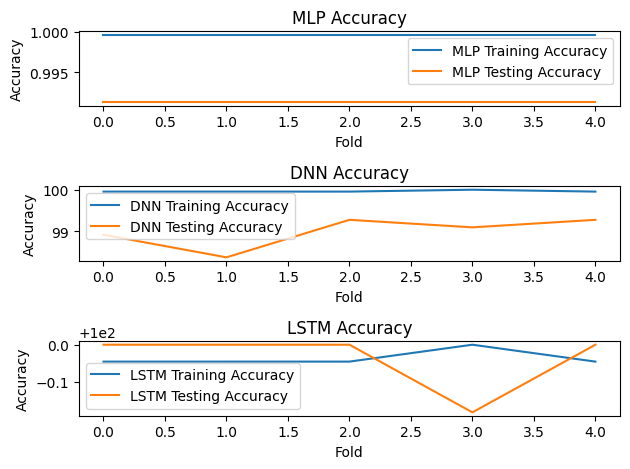

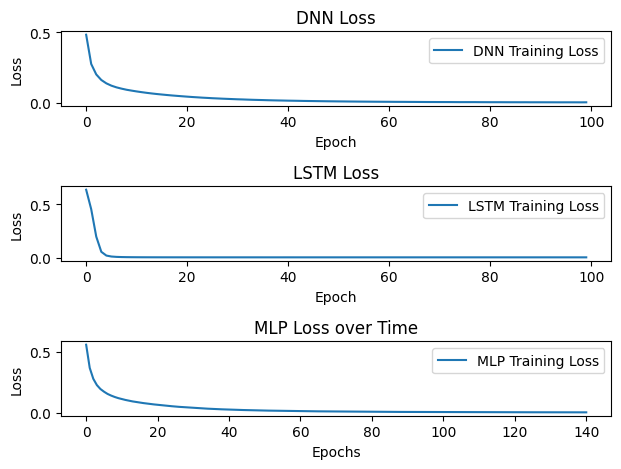

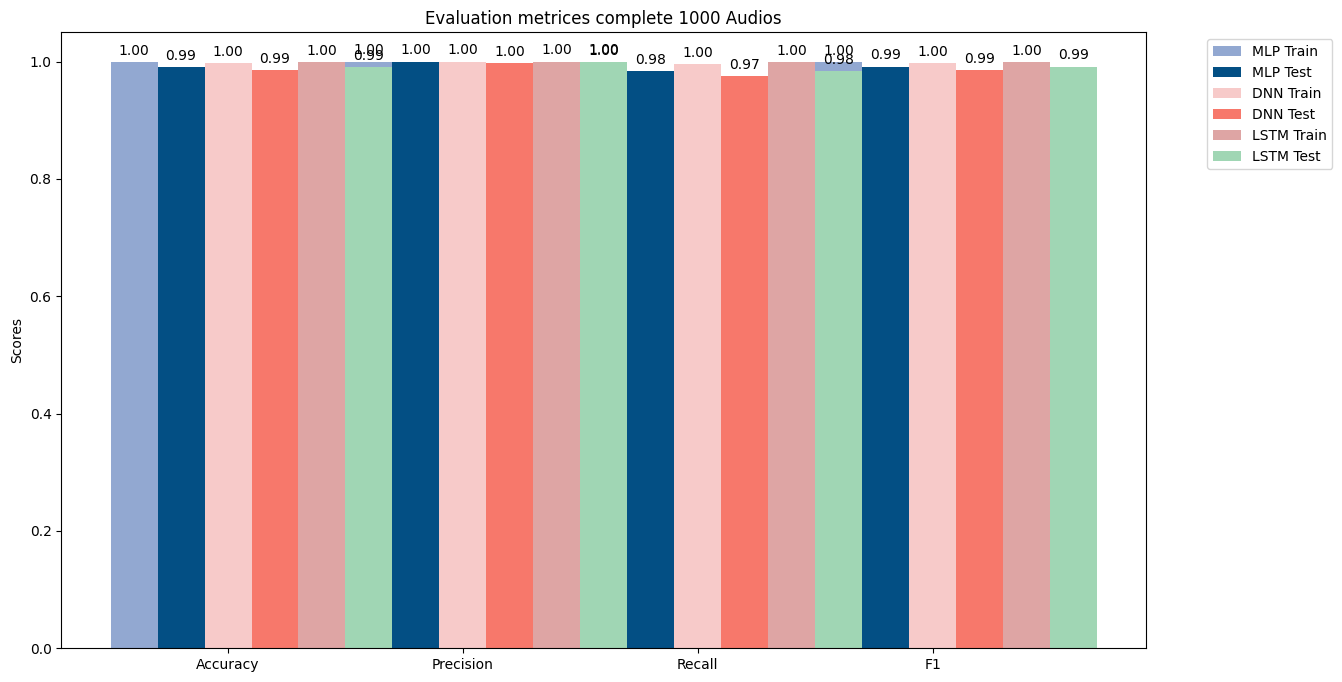

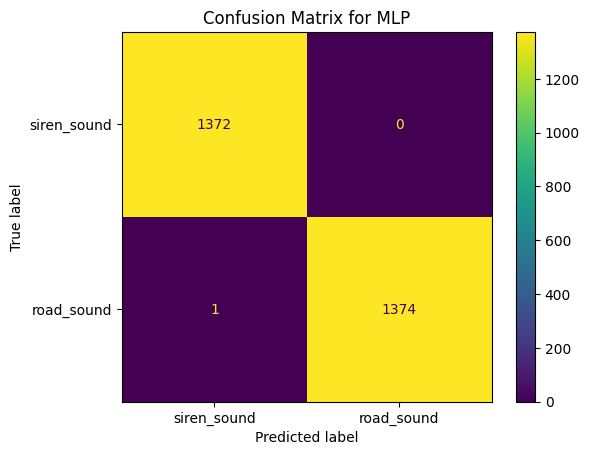

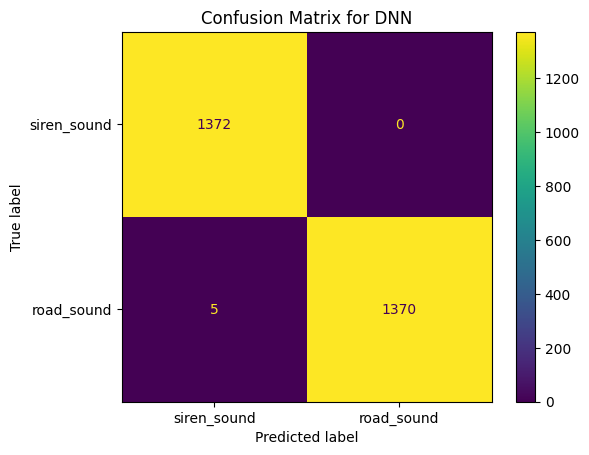

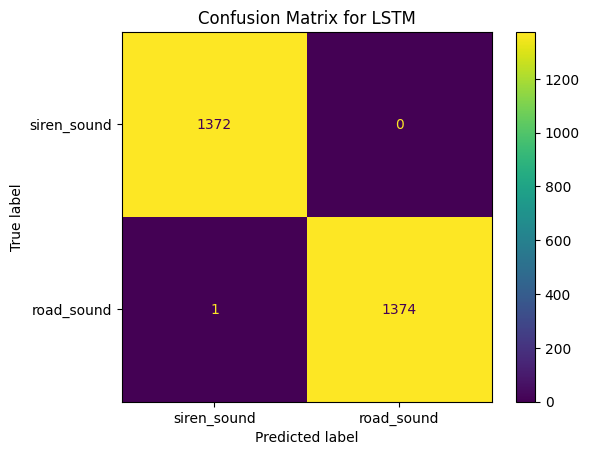

86/86 [==============================] - 0s 2ms/step


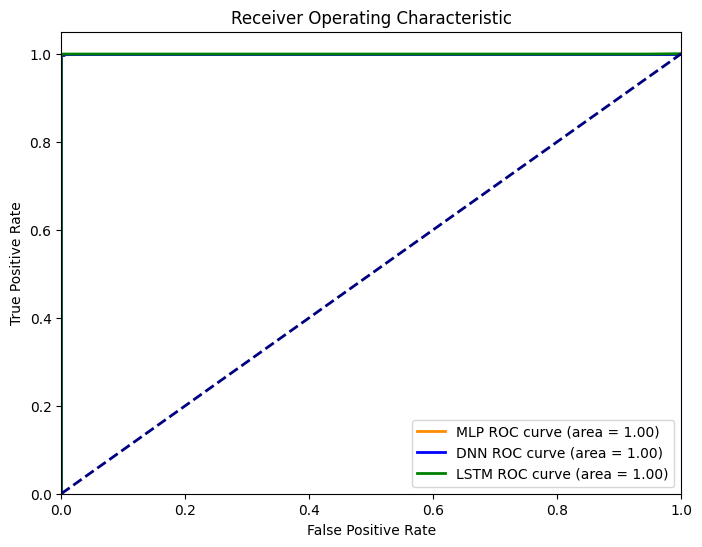

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train a MLPClassifier
mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp.fit(X_train, y_train)


# Use MLP to make predictions on the training data
mlp_train_preds = mlp.predict(X_train)
mlp_test_preds = mlp.predict(X_test)

# Calculate and print MLP accuracy, precision, recall, and F1 score
mlp_train_accuracy = accuracy_score(y_train, mlp_train_preds)
mlp_test_accuracy = accuracy_score(y_test, mlp_test_preds)
mlp_train_precision = precision_score(y_train, mlp_train_preds)
mlp_test_precision = precision_score(y_test, mlp_test_preds)
mlp_train_recall = recall_score(y_train, mlp_train_preds)
mlp_test_recall = recall_score(y_test, mlp_test_preds)
mlp_train_f1 = f1_score(y_train, mlp_train_preds)
mlp_test_f1 = f1_score(y_test, mlp_test_preds)



# Define 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores_dnn_train = []
cvscores_dnn_test = []
cvscores_lstm_train = []
cvscores_lstm_test = []
dnn_train_losses = []
lstm_train_losses=[]

for train, test in kfold.split(X_train, y_train):
    # Define DNN model
    dnn = Sequential()
    dnn.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    dnn.add(Dense(1, activation='sigmoid'))
    dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the DNN model
    history_dnn = dnn.fit(X_train[train], y_train[train], epochs=100, batch_size=32, verbose=0)
    dnn_train_losses.append(history_dnn.history['loss'])

    # Evaluate the DNN model on train and test data
    scores_dnn_train = dnn.evaluate(X_train[train], y_train[train], verbose=0)
    scores_dnn_test = dnn.evaluate(X_train[test], y_train[test], verbose=0)
    cvscores_dnn_train.append(scores_dnn_train[1] * 100)
    cvscores_dnn_test.append(scores_dnn_test[1] * 100)

    # Use the 'predict' function and threshold the results for binary classification
    dnn_preds_proba = dnn.predict(X_train)
    dnn_preds = (dnn_preds_proba > 0.5).astype(int)

    dnn_test_preds = dnn.predict(X_test)
    dnn_test_preds = (dnn_test_preds > 0.5).astype(int)
    # Stack the predictions together to serve as the input for the LSTM model
    stacked_predictions = np.column_stack((mlp_train_preds, dnn_preds))
    stacked_predictions_test = np.column_stack((mlp_test_preds, dnn_test_preds))
    stacked_predictions_test = stacked_predictions_test.reshape((stacked_predictions_test.shape[0], stacked_predictions_test.shape[1], 1))

    # Reshape the stacked predictions to 3D because LSTM expects input to be 3D
    stacked_predictions = stacked_predictions.reshape((stacked_predictions.shape[0], stacked_predictions.shape[1], 1))

    # Define LSTM model
    lstm = Sequential()
    lstm.add(LSTM(32, activation='tanh', input_shape=(stacked_predictions.shape[1], 1)))
    lstm.add(Dense(1, activation='sigmoid'))
    lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the LSTM model
    history_lstm = lstm.fit(stacked_predictions[train], y_train[train], epochs=100, batch_size=32, verbose=0)
    lstm_train_losses.append(history_lstm.history['loss'])

    # Evaluate the LSTM model on train and test data
    scores_lstm_train = lstm.evaluate(stacked_predictions[train], y_train[train], verbose=0)
    scores_lstm_test = lstm.evaluate(stacked_predictions[test], y_train[test], verbose=0)
    cvscores_lstm_train.append(scores_lstm_train[1] * 100)
    cvscores_lstm_test.append(scores_lstm_test[1] * 100)

    dnn_train_precision = precision_score(y_train, dnn_preds, average='binary')
    dnn_train_recall = recall_score(y_train, dnn_preds, average='binary')
    dnn_train_f1 = f1_score(y_train, dnn_preds, average='binary')

    dnn_test_precision = precision_score(y_test, dnn_test_preds, average='binary')
    dnn_test_recall = recall_score(y_test, dnn_test_preds, average='binary')
    dnn_test_f1 = f1_score(y_test, dnn_test_preds, average='binary')
    lstm_train_preds = lstm.predict(stacked_predictions)
    lstm_train_preds = (lstm_train_preds > 0.5).astype(int)
    lstm_train_precision = precision_score(y_train, lstm_train_preds, average='binary')
    lstm_train_recall = recall_score(y_train, lstm_train_preds, average='binary')
    lstm_train_f1 = f1_score(y_train, lstm_train_preds, average='binary')

    lstm_test_preds = lstm.predict(stacked_predictions_test)
    lstm_test_preds = (lstm_test_preds > 0.5).astype(int)
    lstm_test_precision = precision_score(y_test, lstm_test_preds, average='binary')
    lstm_test_recall = recall_score(y_test, lstm_test_preds, average='binary')
    lstm_test_f1 = f1_score(y_test, lstm_test_preds, average='binary')
    dnn_train_accuracy = accuracy_score(y_train, dnn_preds)
    dnn_test_accuracy = accuracy_score(y_test, dnn_test_preds)
    lstm_train_accuracy = accuracy_score(y_train, lstm_train_preds)
    lstm_test_accuracy = accuracy_score(y_test, lstm_test_preds)

print("LSTM Train accuracy =", lstm_train_accuracy)
print("LSTM Test accuracy =", lstm_test_accuracy)
print("DNN Train accuracy =", dnn_train_accuracy)
print("DNN Test accuracy =",  dnn_test_accuracy)
print("MLP Train accuracy =", mlp_test_accuracy)
print("MLP Test accuracy =", mlp_test_accuracy)

fig, axs = plt.subplots(3)
# Plot MLP training and testing accuracy
axs[0].plot([mlp_train_accuracy] * 5, label='MLP Training Accuracy')
axs[0].plot([mlp_test_accuracy] * 5, label='MLP Testing Accuracy')
axs[0].set_title('MLP Accuracy')
axs[0].set_xlabel('Fold')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot DNN training and testing accuracy
axs[1].plot(cvscores_dnn_train, label='DNN Training Accuracy')
axs[1].plot(cvscores_dnn_test, label='DNN Testing Accuracy')
axs[1].set_title('DNN Accuracy')
axs[1].set_xlabel('Fold')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plot LSTM training and testing accuracy
axs[2].plot(cvscores_lstm_train, label='LSTM Training Accuracy')
axs[2].plot(cvscores_lstm_test, label='LSTM Testing Accuracy')
axs[2].set_title('LSTM Accuracy')
axs[2].set_xlabel('Fold')
axs[2].set_ylabel('Accuracy')
axs[2].legend()

# Display the figure with subplots
plt.tight_layout()
plt.show()
fig, axs = plt.subplots(3)

# Plot DNN training loss
axs[0].plot(np.mean(dnn_train_losses, axis=0), label='DNN Training Loss')
axs[0].set_title('DNN Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot LSTM training loss
axs[1].plot(np.mean(lstm_train_losses, axis=0), label='LSTM Training Loss')
axs[1].set_title('LSTM Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Plot MLP loss over epochs
axs[2].plot(mlp.loss_curve_, label='MLP Training Loss')
axs[2].set_title('MLP Loss over Time')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].legend()

# Display the figure with subplots
plt.tight_layout()
plt.show()


# Calculate the average of each metric
dnn_metrics_train = [np.mean(dnn_train_accuracy), np.mean(dnn_train_precision), np.mean(dnn_train_recall), np.mean(dnn_train_f1)]
dnn_metrics_test = [np.mean(dnn_test_accuracy), np.mean(dnn_test_precision), np.mean(dnn_test_recall), np.mean(dnn_test_f1)]

lstm_metrics_train = [np.mean(lstm_train_accuracy), np.mean(lstm_train_precision), np.mean(lstm_train_recall), np.mean(lstm_train_f1)]
lstm_metrics_test = [np.mean(lstm_test_accuracy), np.mean(lstm_test_precision), np.mean(lstm_test_recall), np.mean(lstm_test_f1)]
# Assuming you have already computed the metrics for the MLP model...
mlp_metrics_train = [np.mean(mlp_train_accuracy), np.mean(mlp_train_precision), np.mean(mlp_train_recall), np.mean(mlp_train_f1)]
mlp_metrics_test = [np.mean(mlp_test_accuracy), np.mean(mlp_test_precision), np.mean(mlp_test_recall), np.mean(mlp_test_f1)]

# Define labels and bar width
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars


colors = ['#92a8d1', '#034f84', '#f7cac9', '#f7786b', '#dea5a4', '#a0d6b4']

fig, ax = plt.subplots(figsize=(14, 8))  # Increase figure size
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),  # limit to 2 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# Add MLP bars to the plot
rects1 = ax.bar(x - 2*width, mlp_metrics_train, width, label='MLP Train', color=colors[0])
rects2 = ax.bar(x - width, mlp_metrics_test, width, label='MLP Test', color=colors[1])

# Add DNN and LSTM bars to the plot
rects3 = ax.bar(x, dnn_metrics_train, width, label='DNN Train', color=colors[2])
rects4 = ax.bar(x + width, dnn_metrics_test, width, label='DNN Test', color=colors[3])
rects5 = ax.bar(x + 2*width, lstm_metrics_train, width, label='LSTM Train', color=colors[4])
rects6 = ax.bar(x + 3*width, lstm_metrics_test, width, label='LSTM Test', color=colors[5])  # now colors[5] exists

# Add labels, title, legend, and x-ticks
ax.set_ylabel('Scores')
ax.set_title('Evaluation metrices complete 1000 Audios')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Existing code...
ax.set_xticklabels(labels)

# Adjust the position of the legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Existing code...
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

from sklearn.metrics import confusion_matrix

# Compute confusion matrix for each model
mlp_cm = confusion_matrix(y_train, mlp_train_preds)
dnn_cm = confusion_matrix(y_train, dnn_preds)
lstm_cm = confusion_matrix(y_train, lstm_train_preds)
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix for MLP
disp = ConfusionMatrixDisplay(confusion_matrix=mlp_cm, display_labels=['siren_sound', 'road_sound'])
disp.plot()
plt.title('Confusion Matrix for MLP')
plt.show()

# Plot confusion matrix for DNN
disp = ConfusionMatrixDisplay(confusion_matrix=dnn_cm, display_labels=['siren_sound', 'road_sound'])
disp.plot()
plt.title('Confusion Matrix for DNN')
plt.show()

# Plot confusion matrix for LSTM
disp = ConfusionMatrixDisplay(confusion_matrix=lstm_cm, display_labels=['siren_sound', 'road_sound'])
disp.plot()
plt.title('Confusion Matrix for LSTM')
plt.show()
from sklearn.metrics import roc_curve, auc

# MLP
mlp_preds_proba = mlp.predict_proba(X_train)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_train, mlp_preds_proba)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# DNN
dnn_preds_proba = dnn.predict(X_train).ravel()
fpr_dnn, tpr_dnn, _ = roc_curve(y_train, dnn_preds_proba)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# LSTM
lstm_preds_proba = lstm.predict(stacked_predictions).ravel()
fpr_lstm, tpr_lstm, _ = roc_curve(y_train, lstm_preds_proba)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp)
plt.plot(fpr_dnn, tpr_dnn, color='blue', lw=2, label='DNN ROC curve (area = %0.2f)' % roc_auc_dnn)
plt.plot(fpr_lstm, tpr_lstm, color='green', lw=2, label='LSTM ROC curve (area = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


